# Removing week-day effects and reporting delays

In [1]:
# | default_exp model

In [2]:
# | export
import jax

jax.config.update("jax_enable_x64", True)

In [24]:
# | export
import jax.numpy as jnp
import jax.scipy as jsp
from pyprojroot.here import here
import jax
import jax.random as jrn
from jax import vmap, jit
import matplotlib.pyplot as plt
import matplotlib as mpl

from isssm.typing import PGSSM, GLSSMState
from jaxtyping import Array, Float

from tensorflow_probability.substrates.jax.distributions import (
    NegativeBinomial as NBinom,
)

mpl.rcParams["figure.figsize"] = (20, 6)

## Tuning parameter for methods

In [ ]:
#| export
n_iterations = 20
N_mle = 1000
N_meis = 1000
N_posterior = 10000

key = jrn.PRNGKey(34234234)

# same as in FCH
percentiles_of_interest = jnp.array(
    [0.01, 0.025, *(0.05 * jnp.arange(1, 20)), 0.975, 0.99]
)

## States

We consider states $X_t = \left(\log I_{t}, W_t, \dots, W_{t - 5}, q_{1,t}, q_{2,t}, q_{3,t}\right)$ with

- $\log I_{t + 1} = \log I_{t} + \log \rho_{t}$
- $\log \rho_{t + 1} = \log \rho_{t} + \varepsilon^{\rho}_{t + 1}$
- $M_{t + 1} = -\frac{1}{2}\sigma^{2}_{2} + \varepsilon^M_{t +1 } \sim \mathcal N (-\frac{1}{2} \sigma^{2}_M, \sigma^{2}_M)$, "muck" term (s.t. $\mathbf E M_{t + 1} = 1$)
- $W_{t + 1} = - \sum_{s = 0}^5 W_{t - s} + \varepsilon^W_{t + 1}$ , $\varepsilon^W_{t + 1} \sim \mathcal N(0, \sigma^2_W)$
- $q_{t,\tau} = q_{t,\tau} + \varepsilon_{t + 1}^{q,\tau}$; $\tau = 1,2,3$


Observations are the breakdown of incidences with Meldedatum $t$ into the delays $\tau = 1, \dots$. Note that on date $t$, $Y_t$ is only partially observed:
$$
Y^i_{t} \sim \operatorname{Pois} \left( p_{t,\tau}\exp \left( W_{t} + \log I_{t} + M_{t}\right)\right) = \operatorname{Pois} \left( p_{t,\tau} \exp(W_{t} M_{t}) I_{t}\right),
$$
for $\tau = 1,\dots, 4$, where the parametrization is such that the first parameter is the mean, the second the overdispersion parameter.

Here 
$$
    %p_{t,\tau} = \frac{\exp \left( q_{t,\tau} \right)}{\sum_{j = 1}^{4}\exp \left( q_{j,t} \right)}.
    p_{t,\tau} = \frac{\exp \left( q_{t,\tau} \right)}{1 + \sum_{j = 1}^{3}\exp \left( q_{j,t} \right)},
$$
for $\tau = 1, 2, 3$ and 
$$
    p_{4, t} = \frac{1}{1 + \sum_{j = 1}^{3}\exp \left( q_{j,t} \right)},
$$
similar as in Multinomial logistic regression.

We let 
$$
    \begin{align*}
    S_{t} &= B_{t}X_{t} \\
    &= \left( \log I_{t} + \log W_{t} + M_{t}, q_{1,t}, q_{2,t}, q_{3, t}\right)
    \end{align*}
$$

Now 
$$
    Y_{t}^\tau | S_{t} \sim \operatorname{Pois} \left( p_{t,\tau}\exp \left( \log I_{t} + \log W_{t} + M_{t} \right)\right).
$$
Note the following:

- $Y_t^\tau$ depends on all signals, not just on one, however the observations are still conditionally independent


The parameter $\theta$ of this model is 
$$
    \theta = \left( \log \sigma^{2}_{\log \rho}, \log \sigma^{2}_{W}, \log \sigma^{2}_q , \log \sigma^{2}_{M}\right).
$$


In [5]:
# | export
# Model
from isssm.typing import PGSSM
import jax.scipy.linalg as jsla
from tensorflow_probability.substrates.jax.distributions import Poisson


def to_log_probs(log_ratios):
    exp_q = jnp.exp(log_ratios)
    p_n_delay = 1 / (1 + exp_q.sum(axis=-1, keepdims=True))
    log_p = jnp.log(jnp.concatenate([exp_q * p_n_delay, p_n_delay], axis=-1))
    return log_p


def _model(theta, aux):
    # theta on log scale
    s2_log_r, s2_W, s2_q, s2_M, s2_Wq = jnp.exp(theta)
    np1, n_delay = aux

    n = np1 - 1
    m = 3 + 6 + (n_delay - 1) + 3 * 6
    p = n_delay
    l = 3 + (n_delay - 1) + 3

    # states
    u = jnp.zeros((np1, m))
    u = u.at[:, 2].set(-1 / 2 * s2_M)  # force exp(M_t) to have mean 1

    A_I_rho = jnp.array([[1.0, 1.0], [0.0, 1.0]])
    A_M = jnp.zeros((1, 1))  # muck
    A_W = jnp.array(
        [
            [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
        ]
    )

    A_q = jnp.eye(n_delay - 1)
    # A_q = jnp.block(
    #    [
    #        [jnp.zeros((n_delay - 1, 6 * (n_delay - 1))), jnp.eye(n_delay - 1)],
    #        [jnp.eye(6 * (n_delay - 1)), jnp.zeros((6 * (n_delay - 1), n_delay - 1))],
    #    ]
    # )
    A = jsla.block_diag(A_I_rho, A_M, A_W, A_q, A_W, A_W, A_W)
    v = jnp.zeros((np1, p))

    D = jnp.eye(m)[
        :,
        jnp.array(
            [
                1,
                2,
                3,
                *jnp.arange(3 + 6, 3 + 6 + n_delay - 1),
                *(3 + 6 + n_delay - 1 + jnp.arange(0, 3 * 6, 6)),
            ]
        ),
    ]

    Sigma = jnp.diag(
        jnp.array(
            [
                s2_log_r,
                s2_M,
                s2_W,
                *jnp.repeat(s2_q, n_delay - 1),
                *jnp.repeat(s2_Wq, 3),
            ]
        )
    )

    # large initial variance, diffuse initialization
    Sigma0 = jsla.block_diag(
        25 * jnp.eye(1),  # log I,
        0.2**2 * jnp.eye(1),  # log rho,
        s2_M * jnp.eye(1),  # D
        1 * jnp.eye(6),  # W
        1 * jnp.eye((n_delay - 1)),  # q
        1 * jnp.eye(3 * 6),  # Wq
    )

    B_logI = jnp.eye(n_delay)[:, :1]
    B_logrho = jnp.zeros((n_delay, 1))
    B_logM = jnp.eye(n_delay)[:, :1]
    B_logW = jnp.hstack(
        [
            jnp.eye(n_delay)[:, :1],  # W_t
            jnp.zeros((n_delay, 5)),  # W_t-s
        ]
    )
    B_q = jnp.eye(n_delay)[:, 1:]
    B_Wq = jnp.hstack(
        [
            jnp.eye(n_delay)[:, 1:2],
            jnp.zeros((n_delay, 5)),  # W_t-s
            jnp.eye(n_delay)[:, 2:3],
            jnp.zeros((n_delay, 5)),  # W_t-s
            jnp.eye(n_delay)[:, 3:],
            jnp.zeros((n_delay, 5)),  # W_t-s
        ]
    )
    B = jnp.hstack(
        [
            B_logI,
            B_logrho,
            B_logM,
            B_logW,
            B_q,
            B_Wq,
            # jnp.zeros((n_delay, 6 * (n_delay - 1))),  # q_t-s
        ]
    )

    A = jnp.broadcast_to(A, (n, m, m))
    D = jnp.broadcast_to(D, (n, m, l))
    Sigma = jnp.broadcast_to(Sigma, (n, l, l))
    B = jnp.broadcast_to(B, (np1, p, m))

    def poisson_obs(s, xi):
        log_I_W, q = jnp.split(s, [1], axis=-1)
        log_p = to_log_probs(q)
        log_rate = log_I_W + log_p
        return Poisson(log_rate=log_rate)

    def negbinom_obs(s, xi):
        log_I_W, q = jnp.split(s, [1], axis=-1)
        log_p = to_log_probs(q)
        log_mu = log_I_W + log_p
        return NBinom(r, logits=log_mu - jnp.log(r))

    dist = poisson_obs  # negbinom_obs
    xi = jnp.empty((np1, p, 1))

    return PGSSM(u, A, D, Sigma0, Sigma, v, B, dist, xi)

The `isssm.laplace_approximation` module assumes that $y_{t,i}$ only depends on $\theta_{t,i}$ which is not the case here. To fix this, we monkey-patch both the LA and MEIS.

Additionaly, we have to account for missing values in both methods. If $y_t$ is missing, we transform the model to be 
$$
    y_{t} | s_{t} ~ \delta_{s_{t}}
$$
and $B_t x_t = s_t = 0$. Then $\log p(y_{t} | s_{t}) = 0$ for all $s_t$, with gradient $0_{p}$ and Hessian $0_{p \times p}$. For any initial value of $s_t$ the LA observation is 
$$
    z_{t} =  s_{t} + \underbrace{\ddot p(y_{t}|s_{t})}_{= 0_{p \times p}}~ ^{\dagger} \underbrace{\dot p(y_{t}| s_{t})}_{= 0_{p}} = s_{t} 
$$
with covariance matrix
$$
    \Omega_{t} = \ddot p(y_{t} | s_{t})^{\dagger} = 0_{p\times p}.
$$
which keeps $s_t$ constant. Here $\dagger$ indicates the Moore-Penrose generalized inverse. Thus setting $s_{t} = 0$, this results in a GLSSM where $y_t$ is as if it is missing.

For EIS, the pseudo-observations in the WLS are $\log p(y_{t} | s_{t}^i) = 0$, by a similar argument. Thus the estimates are $\hat\beta_{t} = 0_{2p + 1}$, and, taking pseudo-inverses again, we arrive at the same conclusion.

In [6]:
# | export
def account_for_nans(model: PGSSM, y, missing_indices) -> tuple[PGSSM, Float]:
    # only works for Poisson!
    # missing_indices = jnp.isnan(y)

    y_missing = jnp.nan_to_num(y, nan=0.0)

    v = model.v.at[missing_indices].set(0.0)
    B = model.B.at[missing_indices].set(0.0)

    xi_missing = jnp.ones_like(y).at[missing_indices].set(0.0)[..., None]
    xi = jnp.concatenate([xi_missing, model.xi], -1)

    def missing_dist(s, xi):
        xi_missing, old_xi = xi[..., 0], xi[..., 1:]
        old_dist = model.dist(s, old_xi)
        # if xi == 0. the log rate becomes -inf, so dist is dirac_0
        return Poisson(log_rate=old_dist.log_rate + jnp.log(xi_missing))

    model_missing = PGSSM(
        u=model.u,
        A=model.A,
        D=model.D,
        Sigma0=model.Sigma0,
        Sigma=model.Sigma,
        v=v,
        B=B,
        dist=missing_dist,
        xi=xi,
    )

    return model_missing, y_missing

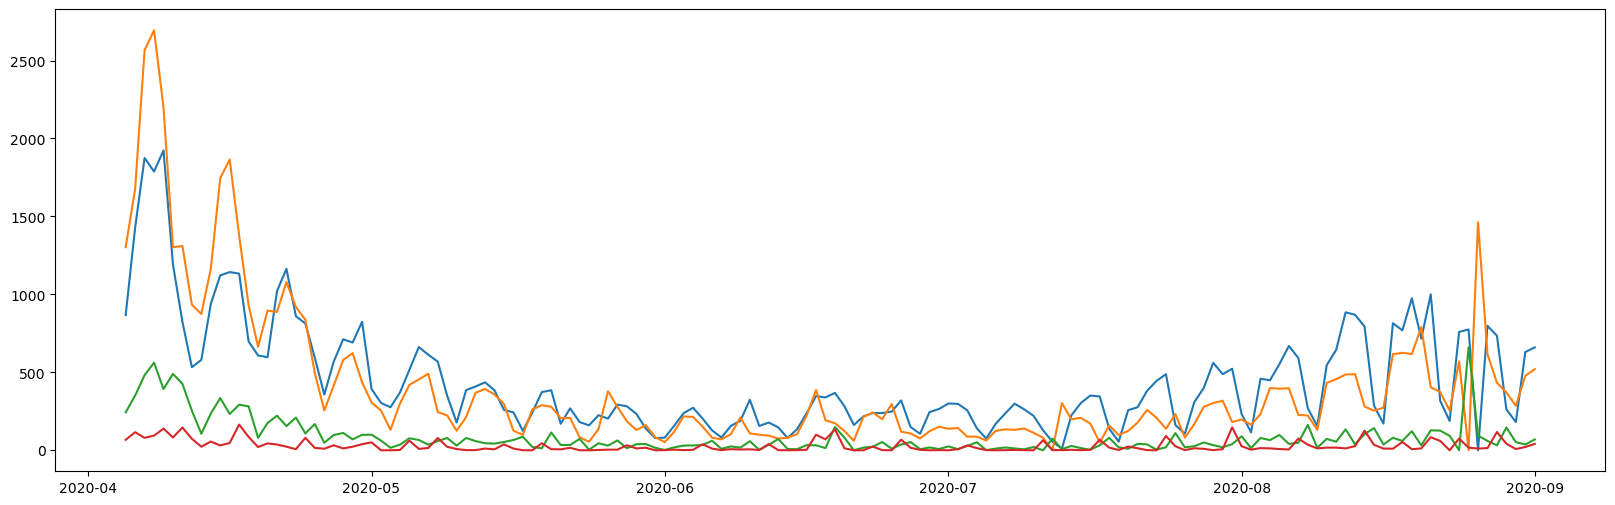

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(here() / "data/processed/RKI_4day_rt.csv")
i_start = 0
np1 = 150
data_selected = df.iloc[i_start : i_start + np1, 1:]
dates = pd.to_datetime(df.iloc[i_start : i_start + np1, 0])
y = jnp.asarray(data_selected.to_numpy())

plt.plot(dates, y)

plt.show()

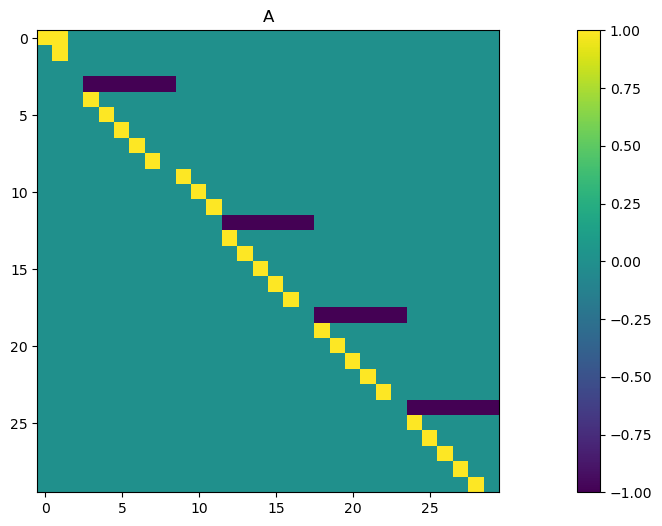

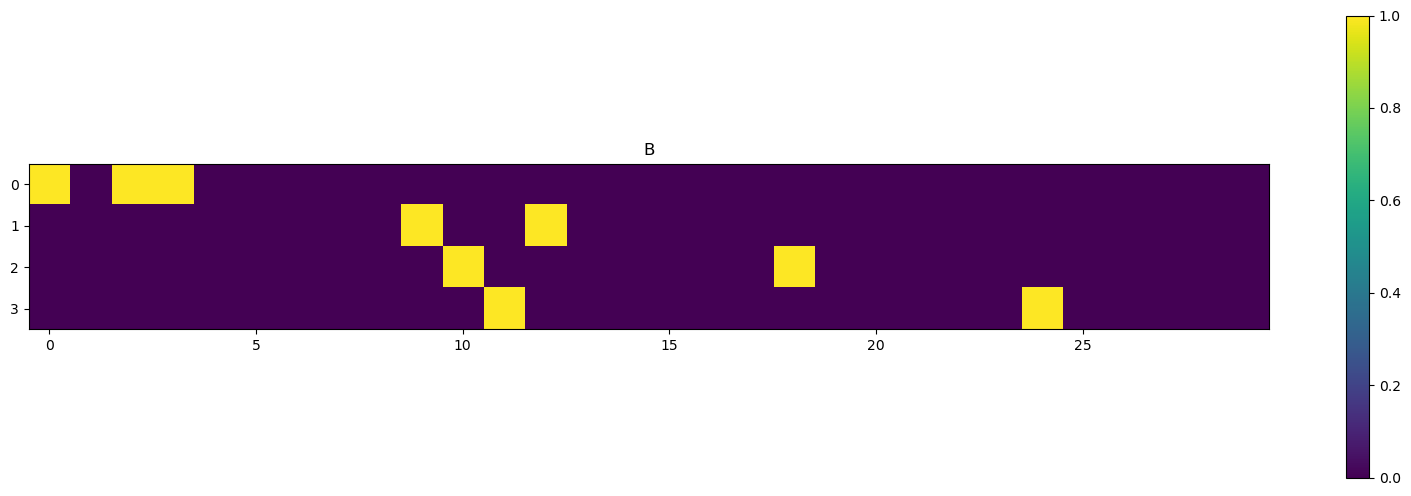

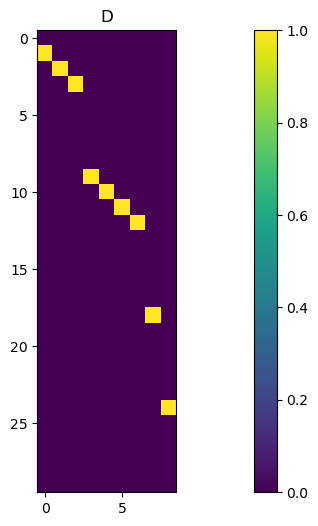

In [8]:
from isssm.importance_sampling import pgssm_importance_sampling, ess_pct
from jax import random as jrn

theta_manual = jnp.log(
    # s2_log_rho, s2_W, s2_q, s2_D
    jnp.array([0.001**2, 0.1**2, 0.5**2, 0.01**2, 0.1**2])
)

# allow variance to be larger as mean
aux = (np1, 4)
pgssm = _model(theta_manual, aux)

plt.title("A")
plt.imshow(pgssm.A[0], aspect=1)
plt.colorbar()
plt.show()
plt.title("B")
plt.imshow(pgssm.B[0], aspect=1)
plt.colorbar()
plt.show()
plt.title("D")
plt.imshow(pgssm.D[0], aspect=1)
plt.colorbar()
plt.show()

## Monkey patching

In [9]:
# | export
# log weights monkey patch
# nansum to account for missing values
# explicitly assumes that s_t = z_t!

from isssm.util import MVN_degenerate as MVN
import isssm.importance_sampling


def log_weights_t(
    s_t: Float[Array, "p"],  # signal
    y_t: Float[Array, "p"],  # observation
    xi_t: Float[Array, "p"],  # parameters
    dist,  # observation distribution
    z_t: Float[Array, "p"],  # synthetic observation
    Omega_t: Float[Array, "p p"],  # synthetic observation covariance, assumed diagonal
) -> Float:  # single log weight
    """Log weight for a single time point."""
    p_ys = dist(s_t, xi_t).log_prob(y_t).sum()

    # omega_t = jnp.sqrt(jnp.diag(Omega_t))
    # g_zs = MVN_diag(s_t, omega_t).log_prob(z_t).sum()
    g_zs = jnp.nansum(MVN(s_t, Omega_t).log_prob(z_t))

    return p_ys - g_zs


def log_weights(
    s: Float[Array, "n+1 p"],  # signals
    y: Float[Array, "n+1 p"],  # observations
    dist,  # observation distribution
    xi: Float[Array, "n+1 p"],  # observation parameters
    z: Float[Array, "n+1 p"],  # synthetic observations
    Omega: Float[Array, "n+1 p p"],  # synthetic observation covariances:
) -> Float:  # log weights
    """Log weights for all time points"""
    p_ys = dist(s, xi).log_prob(y).sum()

    # avoid triangular solve problems
    # omega = jnp.sqrt(vmap(jnp.diag)(Omega))
    # g_zs = MVN_diag(s, omega).log_prob(z).sum()
    g_zs = jnp.nansum(MVN(s, Omega).log_prob(z))

    return p_ys - g_zs


isssm.importance_sampling.log_weights = log_weights
isssm.importance_sampling.log_weights_t = log_weights_t

In [10]:
# | export
# LA monkey patch
from isssm.kalman import kalman, smoothed_signals
from isssm.typing import GLSSM, GLSSMProposal, ConvergenceInformation
from isssm.laplace_approximation import default_link, vvmap, vdiag
from jax.scipy.optimize import minimize
from functools import partial
from isssm.util import converged
from jax import jacfwd, hessian, jacrev
from jax.lax import while_loop
import isssm.laplace_approximation


def _initial_guess(xi_t, y_t, dist, link=default_link):
    result = minimize(
        lambda s_ti: -dist(s_ti, xi_t).log_prob(y_t).sum(),
        jnp.concatenate((jnp.atleast_1d(link(y_t.sum())), jnp.zeros(3))),
        method="BFGS",
    )
    return jnp.squeeze(result.x)


def laplace_approximation(
    y: Float[Array, "n+1 p"],  # observation
    model: PGSSM,
    n_iter: int,  # number of iterations
    log_lik=None,  # log likelihood function
    d_log_lik=None,  # derivative of log likelihood function
    dd_log_lik=None,  # second derivative of log likelihood function
    eps: Float = 1e-5,  # precision of iterations
    link=default_link,  # default link to use in initial guess
) -> tuple[GLSSMProposal, ConvergenceInformation]:
    u, A, D, Sigma0, Sigma, v, B, dist, xi = model
    np1, p, m = B.shape

    # s_init = vmap(partial(_initial_guess, dist=dist, link=link))(xi, y)
    # missing values have zero obs. -> 0.
    s_init = jnp.hstack(
        (jnp.log(y.sum(axis=1, keepdims=True) + 1.0), jnp.zeros((np1, 3)))
    )

    def default_log_lik(
        s_t: Float[Array, "p"], xi_t: Float[Array, "p"], y_t: Float[Array, "p'"]
    ):
        return dist(s_t, xi_t).log_prob(y_t).sum()

    if log_lik is None:
        log_lik = default_log_lik

    if d_log_lik is None:
        d_log_lik = jacfwd(log_lik, argnums=0)
    if dd_log_lik is None:
        dd_log_lik = jacrev(d_log_lik, argnums=0)

    vd_log_lik = jit(vmap(d_log_lik))
    vdd_log_lik = jit(vmap(dd_log_lik))

    def _break(val):
        _, i, z, Omega, z_old, Omega_old = val

        z_converged = jnp.logical_and(converged(z, z_old, eps), i > 0)
        Omega_converged = jnp.logical_and(converged(Omega, Omega_old, eps), i > 0)
        all_converged = jnp.logical_and(z_converged, Omega_converged)

        iteration_limit_reached = i >= n_iter

        return jnp.logical_or(all_converged, iteration_limit_reached)

    def _iteration(val):
        s, i, z_old, Omega_old, _, _ = val

        grad = vd_log_lik(s, xi, y)
        Gamma = -vdd_log_lik(s, xi, y)
        # pinv for missing values: if Gamma is 0, we want Omega to be 0 as well
        # requries exact derivatives, not numerical ones!
        Omega = jnp.linalg.pinv(Gamma, hermitian=True)

        # z = s + jnp.linalg.solve(Gamma, grad[..., None])[..., 0]
        z = s + (Omega @ grad[..., None])[..., 0]
        approx_glssm = GLSSM(u, A, D, Sigma0, Sigma, v, B, Omega)

        filtered = kalman(z, approx_glssm)
        s_new = smoothed_signals(filtered, z, approx_glssm)

        return s_new, i + 1, z, Omega, z_old, Omega_old

    empty_z = jnp.empty_like(s_init)
    empty_Omega = jnp.empty((np1, p, p))
    init = (s_init, 0, empty_z, empty_Omega, empty_z, empty_Omega)

    _keep_going = lambda *args: jnp.logical_not(_break(*args))
    _, n_iters, z, Omega, z_old, Omega_old = while_loop(_keep_going, _iteration, init)

    final_proposal = GLSSMProposal(u, A, D, Sigma0, Sigma, v, B, Omega, z)
    delta_z = jnp.max(jnp.abs(z - z_old))
    delta_Omega = jnp.max(jnp.abs(Omega - Omega_old))
    information = ConvergenceInformation(
        converged=jnp.logical_and(
            converged(z, z_old, eps), converged(Omega, Omega_old, eps)
        ),
        n_iter=n_iters,
        delta=jnp.max(jnp.array([delta_z, delta_Omega])),
    )
    return final_proposal, information


isssm.laplace_approximation._initial_guess = _initial_guess
isssm.laplace_approximation.laplace_approximation = laplace_approximation

In [11]:
# | export
# MEIS monkey patch
import jax.random as jrn
from jaxtyping import PRNGKeyArray
from isssm.importance_sampling import normalize_weights, log_weights_t
from isssm.kalman import simulation_smoother
import isssm.modified_efficient_importance_sampling


def triu(entries: Float[Array, " q"], p: int):
    (q,) = entries.shape

    if 2 * q != p * (p + 1):
        raise ValueError(
            f"entries does not have the correct shape, expected {int(p * (p - 1) /2)} entries in the second dimension but got {q}"
        )

    mat = jnp.zeros((p, p))
    mat = mat.at[jnp.triu_indices(p)].set(entries)

    return mat


def tril(entries: Float[Array, " q"], p: int):
    (q,) = entries.shape

    if 2 * q != p * (p + 1):
        raise ValueError(
            f"entries does not have the correct shape, expected {int(p * (p - 1) /2)} entries in the second dimension but got {q}"
        )

    mat = jnp.zeros((p, p))
    mat = mat.at[jnp.tril_indices(p)].set(entries)

    return mat


@jit
def optimal_parameters(
    signal: Float[Array, "N p"], weights: Float[Array, "N"], log_p: Float[Array, "N"]
):
    N, p = signal.shape
    ones = jnp.ones_like(weights)[:, None]

    second_moment = vmap(jnp.outer)(signal, signal)
    # double tranpose, because [:, jnp.tril_indices(p)] is not supported (returns (N, 2, p(p-1)/2, 4) instead of (N, p(p-1)/2)
    lower_tri_second_moment = second_moment.transpose((1, 2, 0))[jnp.tril_indices(p)].T

    # w_inner_prod = lambda a, b: jnp.einsum("i,ij,ik->jk", weights, a, b)
    # X_T_W_X = jnp.block(
    #    [
    #        [
    #            w_inner_prod(ones, ones),
    #            w_inner_prod(ones, signal),
    #            w_inner_prod(ones, -0.5 * lower_tri_second_moment),
    #        ],
    #        [
    #            w_inner_prod(signal, ones),
    #            w_inner_prod(signal, signal),
    #            w_inner_prod(signal, -0.5 * lower_tri_second_moment),
    #        ],
    #        [
    #            w_inner_prod(-0.5 * lower_tri_second_moment, ones),
    #            w_inner_prod(-0.5 * lower_tri_second_moment, signal),
    #            w_inner_prod(
    #                -0.5 * lower_tri_second_moment, -0.5 * lower_tri_second_moment
    #            ),
    #        ],
    #    ]
    # )
    # X_T_W_y = jnp.concatenate(
    #    [
    #        w_inner_prod(ones, log_p[:, None]),
    #        w_inner_prod(signal, log_p[:, None]),
    #        w_inner_prod(-0.5 * lower_tri_second_moment, log_p[:, None]),
    #    ]
    # )

    design = jnp.hstack([ones, signal, -0.5 * lower_tri_second_moment])
    lhs = log_p

    sqrt_weights = jnp.sqrt(weights)

    design_W = design * sqrt_weights[:, None]
    lhs_W = lhs * sqrt_weights

    # if lhs_W is 0, this returns 0 even if design matrix does not have full rank (numpy promises solution with least l2-norm)
    beta, *_ = jnp.linalg.lstsq(design_W, lhs_W)
    return beta
    # beta = jnp.linalg.solve(X_T_W_X, X_T_W_y[:, 0])
    # return beta


def modified_efficient_importance_sampling(
    y: Float[Array, "n+1 p"],  # observations
    model: PGSSM,  # model
    z_init: Float[Array, "n+1 p"],  # initial z estimate
    Omega_init: Float[Array, "n+1 p p"],  # initial Omega estimate
    n_iter: int,  # number of iterations
    N: int,  # number of samples
    key: PRNGKeyArray,  # random key
    eps: Float = 1e-5,  # convergence threshold
):
    z, Omega = z_init, Omega_init

    np1, p, m = model.B.shape

    key, crn_key = jrn.split(key)

    v_norm_w = vmap(normalize_weights)
    dist = model.dist
    lw_t = vmap(
        vmap(lambda s, y, xi, z, Omega: log_weights_t(s, y, xi, dist, z, Omega)),
        (0, None, None, None, None),
    )

    def _break(val):
        i, z, Omega, z_old, Omega_old = val

        # in first iteration we don't have old values, converged is True for NaNs
        z_converged = jnp.logical_and(converged(z, z_old, eps), i > 0)
        Omega_converged = jnp.logical_and(converged(Omega, Omega_old, eps), i > 0)
        iteration_limit_reached = i >= n_iter

        return jnp.logical_or(
            jnp.logical_and(z_converged, Omega_converged), iteration_limit_reached
        )

    def _iteration(val):
        i, z, Omega, _, _ = val
        glssm_approx = GLSSM(
            model.u,
            model.A,
            model.D,
            model.Sigma0,
            model.Sigma,
            model.v,
            model.B,
            Omega,
        )
        sim_signal = simulation_smoother(glssm_approx, z, N, crn_key)

        log_weights = lw_t(sim_signal, y, model.xi, z, Omega)
        log_p = dist(sim_signal, model.xi).log_prob(y).sum(axis=-1)
        wls_estimate = vmap(optimal_parameters, (1, 1, 1), 0)(
            sim_signal, v_norm_w(log_weights), log_p
        )

        a = wls_estimate[:, 0]
        b = wls_estimate[:, 1 : (p + 1)]
        c = wls_estimate[:, (p + 1) :]

        Omega_inv_new = vmap(tril, (0, None))(c, p)
        Omega_inv_new = 1 / 2 * (Omega_inv_new + Omega_inv_new.transpose((0, 2, 1)))
        # pinv for missing cases
        Omega_new = jnp.linalg.pinv(Omega_inv_new, hermitian=True)
        z_new = (Omega_new @ b[..., None])[..., 0]

        return i + 1, z_new, Omega_new, z, Omega

    _keep_going = lambda *args: jnp.logical_not(_break(*args))

    init = (0, z_init, Omega_init, jnp.empty_like(z_init), jnp.empty_like(Omega_init))
    n_iters, z, Omega, z_old, Omega_old = while_loop(_keep_going, _iteration, init)

    proposal = GLSSMProposal(
        model.u, model.A, model.D, model.Sigma0, model.Sigma, model.v, model.B, Omega, z
    )

    delta_z = jnp.max(jnp.abs(z - z_old))
    delta_Omega = jnp.max(jnp.abs(Omega - Omega_old))
    information = ConvergenceInformation(
        converged=jnp.logical_and(
            converged(z, z_old, eps), converged(Omega, Omega_old, eps)
        ),
        n_iter=n_iters,
        delta=jnp.max(jnp.array([delta_z, delta_Omega])),
    )

    return proposal, information


isssm.modified_efficient_importance_sampling.modified_efficient_importance_sampling = (
    modified_efficient_importance_sampling
)

In [ ]:
#| export
# monkey patch gnll to handle nans
vmm = vmap(jnp.matmul, (0,0))
from isssm.util import MVN_degenerate as MVN
import isssm.estimation
@jit
def gnll(
    y: Float[Array, "n+1 p"],  # observations $y_t$
    x_pred: Float[Array, "n+1 m"],  # predicted states $\hat X_{t+1\bar t}$
    Xi_pred: Float[Array, "n+1 m m"],  # predicted state covariances $\Xi_{t+1\bar t}$
    B: Float[Array, "n+1 p m"],  # state observation matrices $B_{t}$
    Omega: Float[Array, "n+1 p p"],  # observation covariances $\Omega_{t}$
) -> Float:  # gaussian negative log-likelihood
    """Gaussian negative log-likelihood"""
    y_pred = vmm(B, x_pred)
    Psi_pred = vmm(vmm(B, Xi_pred), jnp.transpose(B, (0, 2, 1))) + Omega

    return jnp.nansum(-MVN(y_pred, Psi_pred).log_prob(y))

isssm.estimation.gnll = gnll

In [12]:
from isssm.laplace_approximation import laplace_approximation
from isssm.modified_efficient_importance_sampling import (
    modified_efficient_importance_sampling as MEIS,
)

key = jrn.PRNGKey(123423423)

In [13]:
from isssm.estimation import mle_pgssm, initial_theta

initial_result = initial_theta(y, _model, theta_manual, aux, 20)
theta0 = initial_result.x
initial_result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5.692800563209951
        x: [-8.423e+00 -7.476e+00 -4.235e+00 -3.989e+00 -4.155e-01]
      nit: 54
      jac: [ 2.859e-08  9.477e-08 -5.204e-07 -2.981e-07  3.293e-07]
 hess_inv: [[ 2.131e+02  9.608e+00 ... -2.118e+01  1.941e-01]
            [ 9.608e+00  1.806e+02 ... -1.266e+01  4.999e-02]
            ...
            [-2.118e+01 -1.266e+01 ...  1.930e+01  1.884e-01]
            [ 1.941e-01  4.999e-02 ...  1.884e-01  8.456e+00]]
     nfev: 660
     njev: 60

In [14]:
# key, subkey = jrn.split(key)
# mle_result = mle_pgssm(y, _model, theta0, aux, 20, 1000, subkey)
# theta_hat = mle_result.x
# mle_result

theta_hat = theta0

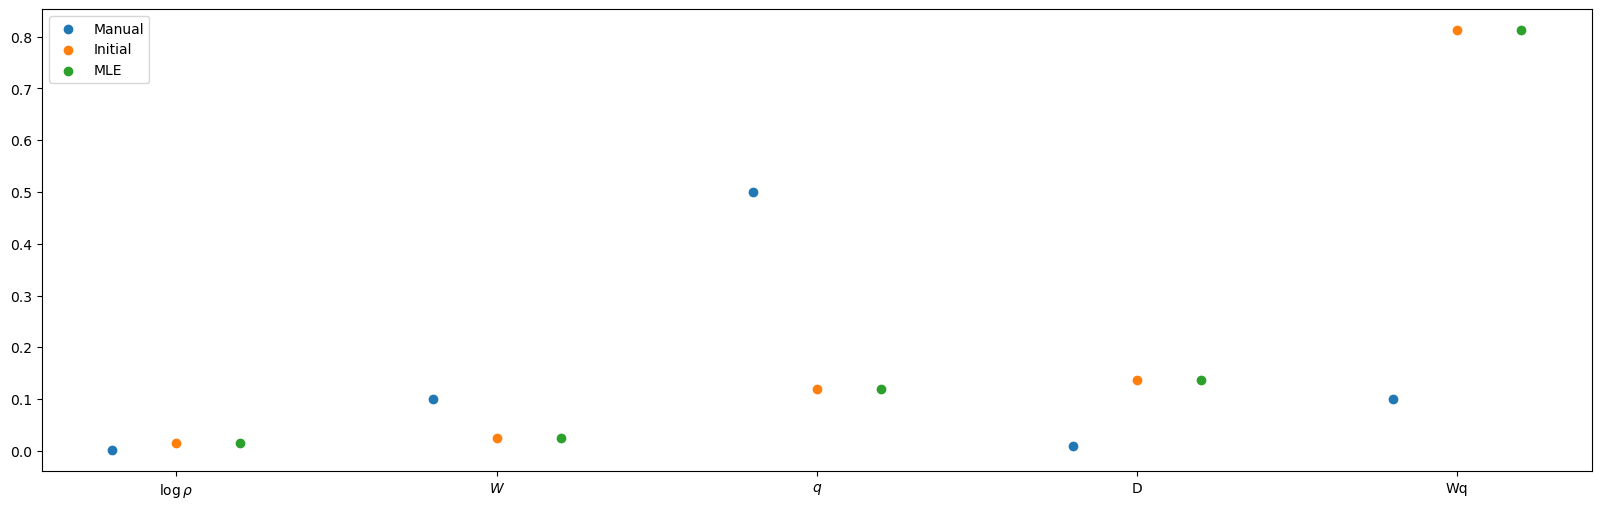

In [15]:
s_manual = jnp.exp(theta_manual / 2)
s_0 = jnp.exp(theta0 / 2)

k = theta_manual.size
plt.scatter(jnp.arange(k) - 0.2, s_manual, label="Manual")
plt.scatter(jnp.arange(k), s_0, label="Initial")
s_mle = jnp.exp(theta_hat / 2)
plt.scatter(jnp.arange(k) + 0.2, s_mle, label="MLE")
plt.xticks(jnp.arange(k), ["$\\log \\rho$", "$W$", "$q$", "D", "Wq"])
plt.legend()
plt.show()

In [16]:
fitted_model = _model(theta0, aux)

proposal_la, _ = laplace_approximation(y, fitted_model, 100)
key, subkey = jrn.split(key)
proposal_meis, _ = MEIS(
    y, fitted_model, proposal_la.z, proposal_la.Omega, 10, int(1e4), subkey
)

key, subkey = jrn.split(key)
samples_meis, log_weights_meis = pgssm_importance_sampling(
    y, fitted_model, proposal_meis.z, proposal_meis.Omega, 10000, subkey
)
key, subkey = jrn.split(key)
samples_la, log_weights_la = pgssm_importance_sampling(
    y, fitted_model, proposal_la.z, proposal_la.Omega, 10000, subkey
)
ess_pct(log_weights_la), ess_pct(log_weights_meis)

(Array(3.7199269, dtype=float64), Array(28.55789803, dtype=float64))

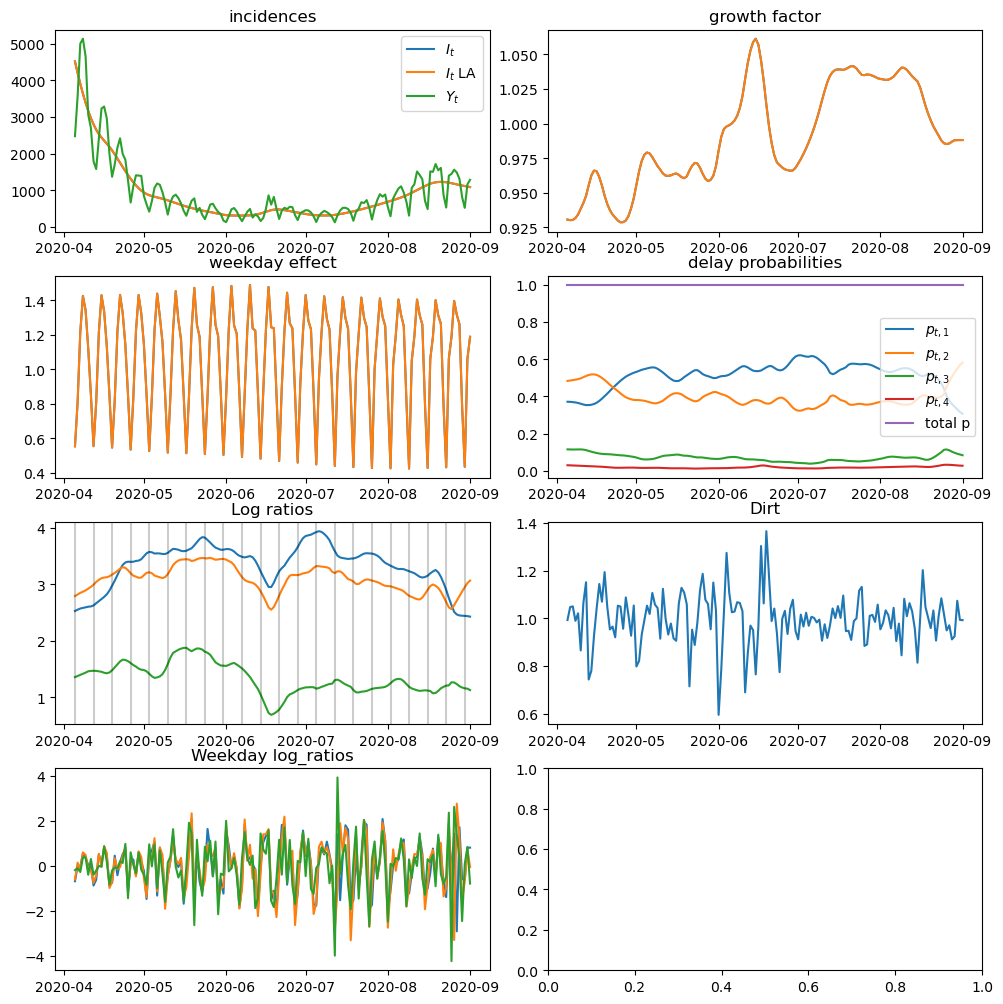

In [17]:
from isssm.importance_sampling import normalize_weights, mc_integration
from isssm.typing import GLSSM
from isssm.kalman import kalman, smoother, state_mode
from isssm.laplace_approximation import posterior_mode
from isssm.util import mm_time

signal_la = posterior_mode(proposal_la)

state_modes_meis = vmap(state_mode, (None, 0))(fitted_model, samples_meis)
x_smooth = mc_integration(state_modes_meis, log_weights_meis)

x_smooth_la = state_mode(fitted_model, signal_la)

# plt.plot(jnp.exp(x_smooth[:, 12]), label="smoothed")
# plt.plot(jnp.exp(x_smooth[:, 2:8].sum(axis=1)), label="smoothed")
# plt.plot(jnp.exp(x_smooth[:, 0]), label="smoothed")
# plt.plot(y.sum(axis=1), label="Y")
# plt.plot(jnp.exp(x_smooth[:, 1]), label="smoothed")

I_smooth = jnp.exp(x_smooth[:, 0])
I_smooth_LA = jnp.exp(x_smooth_la[:, 0])

rho_smooth = jnp.exp(x_smooth[:, 1])
rho_smooth_LA = jnp.exp(x_smooth_la[:, 1])

D_smooth = jnp.exp(x_smooth[:, 2])
D_smooth_LA = jnp.exp(x_smooth_la[:, 2])

W_smooth = jnp.exp(x_smooth[:, 3])
W_smooth_LA = jnp.exp(x_smooth_la[:, 3])

log_ratios = x_smooth[:, 9:12]
log_probs = to_log_probs(log_ratios)

fig, axs = plt.subplots(4, 2, figsize=(10, 10))

axs = axs.flatten()
fig.tight_layout()

axs[0].set_title("incidences")
axs[0].plot(dates, I_smooth, label="$I_t$")
axs[0].plot(dates, I_smooth_LA, label="$I_t$ LA")
axs[0].plot(dates, y.sum(axis=1), label="$Y_t$")
axs[0].legend()

axs[1].set_title("growth factor")
axs[1].plot(dates, rho_smooth, label="$\\log \\rho_t$")
axs[1].plot(dates, rho_smooth_LA, label="$\\log \\rho_t$ LA")

axs[2].set_title("weekday effect")
axs[2].plot(dates, W_smooth, label="$W_t$")
axs[2].plot(dates, W_smooth_LA, label="$W_t$ LA")

axs[3].set_title("delay probabilities")


axs[3].plot(dates, jnp.exp(log_probs[:, 0]), label="$p_{t, 1}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 1]), label="$p_{t, 2}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 2]), label="$p_{t, 3}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 3]), label="$p_{t, 4}$")
axs[3].plot(dates, jnp.exp(log_probs).sum(axis=1), label="total p")
axs[3].legend()

axs[4].set_title("Log ratios")
axs[4].plot(dates, log_ratios[:, 0], label="$q_{t, 1}$")
axs[4].plot(dates, log_ratios[:, 1], label="$q_{t, 2}$")
axs[4].plot(dates, log_ratios[:, 2], label="$q_{t, 3}$")
for d in dates[::7]:
    axs[4].axvline(d, color="black", alpha=0.2)

axs[5].set_title("Dirt")
axs[5].plot(dates, D_smooth)

axs[6].set_title("Weekday log_ratios")
axs[6].plot(dates, x_smooth[:, jnp.array([13, 19, 25])])
plt.show()

In [23]:
# | hide
from nbdev import export

export.nb_export("10_model_utils.ipynb", "src")

## Christmas period model

In [61]:
dates.iloc[110]

Timestamp('2021-01-20 00:00:00')

In [62]:
christmas_inds = jnp.arange(75, 110)
y_nans = y.astype(jnp.float64).at[christmas_inds].set(jnp.nan)
christmas_inds = jnp.isnan(y_nans)
_model_miss = lambda theta, aux: account_for_nans(
    _model(theta, aux), y_nans, christmas_inds
)[0]
theta0_miss = initial_theta(y_miss, _model_miss, theta_manual, aux, 100)
model_miss, y_miss = account_for_nans(
    _model(theta0_miss.x, aux), y_nans, christmas_inds
)
proposal_la_miss, _ = laplace_approximation(y_miss, model_miss, 100)
key, subkey = jrn.split(key)
proposal_meis_miss, _ = MEIS(
    y_miss, model_miss, proposal_la_miss.z, proposal_la_miss.Omega, 10, 4000, subkey
)

key, subkey = jrn.split(key)
missing_samples, missing_log_weights = pgssm_importance_sampling(
    y_miss,
    model_miss,
    proposal_meis_miss.z,
    proposal_meis.Omega,
    1000,
    subkey,
)
ess_pct(missing_log_weights)

Array(0.0496248, dtype=float64)

In [63]:
ess_pct(missing_log_weights)

Array(0.0496248, dtype=float64)

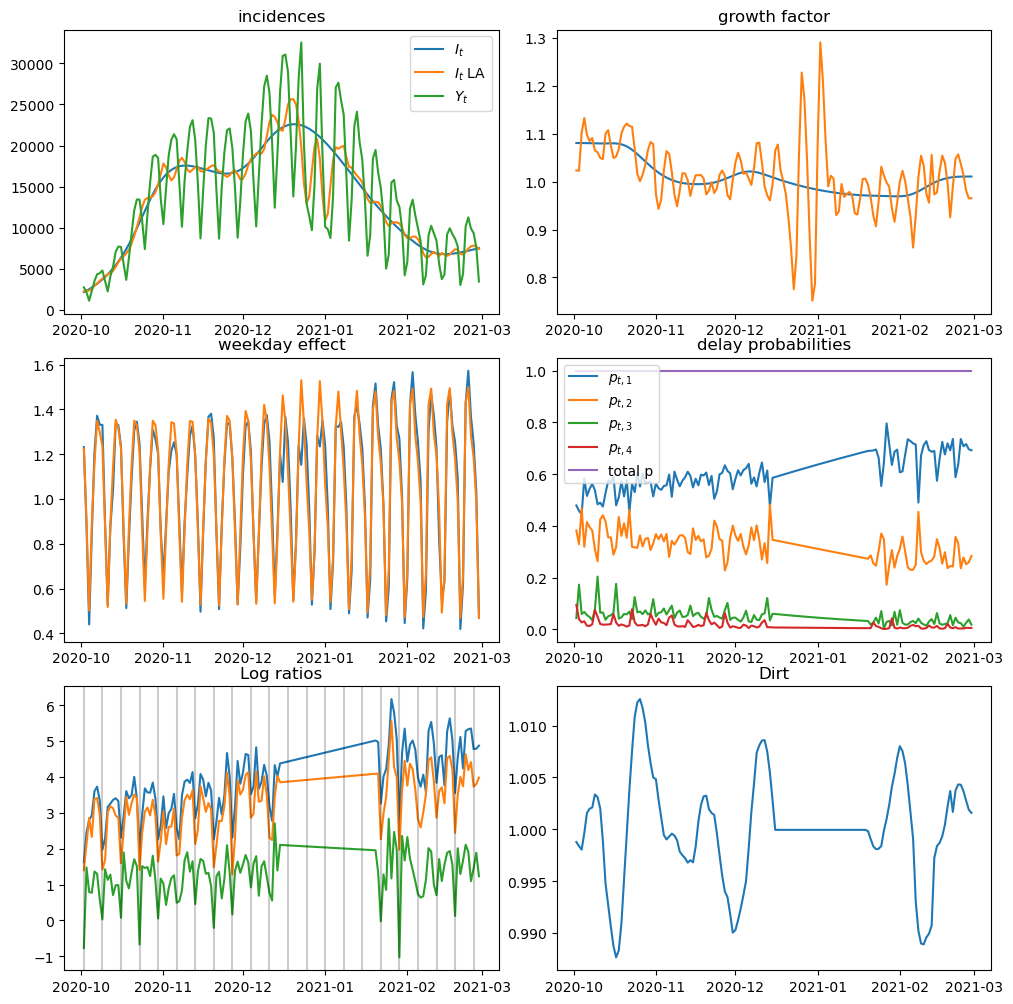

In [64]:
x_smooth = (
    # vmap(smooth_x)(samples_la) * normalize_weights(log_weights_la)[:, None, None]
    vmap(state_mode, (None, 0))(model_miss, missing_samples)
    * normalize_weights(missing_log_weights)[:, None, None]
).sum(axis=0)


# plt.plot(jnp.exp(x_smooth[:, 12]), label="smoothed")
# plt.plot(jnp.exp(x_smooth[:, 2:8].sum(axis=1)), label="smoothed")
# plt.plot(jnp.exp(x_smooth[:, 0]), label="smoothed")
# plt.plot(y.sum(axis=1), label="Y")
# plt.plot(jnp.exp(x_smooth[:, 1]), label="smoothed")

I_smooth = jnp.exp(x_smooth[:, 0])
I_smooth_LA = jnp.exp(x_smooth_la[:, 0])

rho_smooth = jnp.exp(x_smooth[:, 1])
rho_smooth_LA = jnp.exp(x_smooth_la[:, 1])

D_smooth = jnp.exp(x_smooth[:, 2])
D_smooth_LA = jnp.exp(x_smooth_la[:, 2])

W_smooth = jnp.exp(x_smooth[:, 3])
W_smooth_LA = jnp.exp(x_smooth_la[:, 3])

log_ratios = x_smooth[:, 9:12]
log_probs = to_log_probs(log_ratios)

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

axs = axs.flatten()
fig.tight_layout()

axs[0].set_title("incidences")
axs[0].plot(dates, I_smooth, label="$I_t$")
axs[0].plot(dates, I_smooth_LA, label="$I_t$ LA")
axs[0].plot(dates, y.sum(axis=1), label="$Y_t$")
axs[0].legend()

axs[1].set_title("growth factor")
axs[1].plot(dates, rho_smooth, label="$\\log \\rho_t$")
axs[1].plot(dates, rho_smooth_LA, label="$\\log \\rho_t$ LA")

axs[2].set_title("weekday effect")
axs[2].plot(dates, W_smooth, label="$W_t$")
axs[2].plot(dates, W_smooth_LA, label="$W_t$ LA")

axs[3].set_title("delay probabilities")


axs[3].plot(dates, jnp.exp(log_probs[:, 0]), label="$p_{t, 1}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 1]), label="$p_{t, 2}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 2]), label="$p_{t, 3}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 3]), label="$p_{t, 4}$")
axs[3].plot(dates, jnp.exp(log_probs).sum(axis=1), label="total p")
axs[3].legend()

axs[4].set_title("Log ratios")
axs[4].plot(dates, log_ratios[:, 0], label="$q_{t, 1}$")
axs[4].plot(dates, log_ratios[:, 1], label="$q_{t, 2}$")
axs[4].plot(dates, log_ratios[:, 2], label="$q_{t, 3}$")
for d in dates[::7]:
    axs[4].axvline(d, color="black", alpha=0.2)

axs[5].set_title("Dirt")
axs[5].plot(dates, D_smooth)
plt.show()

In [26]:
# | hide
from nbdev import export

export.nb_export("10_model_utils.ipynb", "src")